# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

  Using cached https://files.pythonhosted.org/packages/69/ec/8221a07850d69fa3c57c02e526edd23d18c7c05d58ed103e3b19172757c1/PyVirtualDisplay-0.2.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/32/8f/88d636f1da22a3c573259e44cfefb46a117d3f9432e2c98b1ab4a21372ad/EasyProcess-0.2.10-py2.py3-none-any.whl


### 2. Define the Architecture of the Policy

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


In [3]:
p = torch.Tensor([0.1, 0.4, 0.2, 0.3])
m = Categorical(p)
action = m.sample()
print(action.item(), m.log_prob(action))

3 tensor(-1.2040)


In [4]:
import torch, random
gamma = 0.99
rewards = [1]*5
dis = [gamma**i for i in range(len(rewards)+1)]
R = sum([a*b for a,b in zip(dis, rewards)])
for a,b in zip(dis, rewards):
    print(a,b)

1.0 1
0.99 1
0.9801 1
0.970299 1
0.96059601 1


### 3. Train the Agent with REINFORCE

In [ ]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=10000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards))]## does not really affect increasing discount size by 1
                            ## zip only takes values which are equal in index till rewards length and discard extra
                            ## indxe value for discount. 
        R = sum([a*b for a,b in zip(discounts, rewards)])
#         print(len(discounts), len(rewards))
        
        policy_loss = []
        for log_prob in saved_log_probs:
            ## negative becoz it computes for the gradient descent, we want to go in the negative direction.
            ## gradient ascent 
            
            ## loss for each action
            policy_loss.append(-log_prob*R)
            
#         print('list', policy_loss)
        p_s = policy_loss
        p_s = torch.cat(p_s).sum()
#         print('p_s', p_s)
        policy_loss = torch.cat(policy_loss).sum()## total loss for the entire episode
#         print('cat', policy_loss)
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(policy.state_dict(), 'REINFORCE_cartpole_checkpoint.pth')
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 14.05
Episode 200	Average Score: 23.83
Episode 300	Average Score: 41.52
Episode 400	Average Score: 44.29
Episode 500	Average Score: 60.74
Episode 600	Average Score: 69.49
Episode 700	Average Score: 67.92
Episode 800	Average Score: 92.31
Episode 900	Average Score: 90.43
Episode 1000	Average Score: 85.56
Episode 1100	Average Score: 89.55
Episode 1200	Average Score: 130.40
Episode 1300	Average Score: 106.01
Episode 1400	Average Score: 107.71
Episode 1500	Average Score: 136.92
Episode 1600	Average Score: 102.35
Episode 1700	Average Score: 128.69
Episode 1800	Average Score: 95.64
Episode 1900	Average Score: 129.32
Episode 2000	Average Score: 175.63
Episode 2100	Average Score: 160.14
Episode 2200	Average Score: 140.27
Episode 2300	Average Score: 138.28


### 4. Plot the Scores

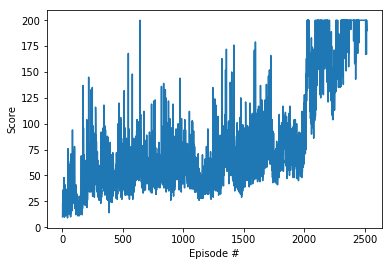

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [4]:
policy = Policy().to(device)

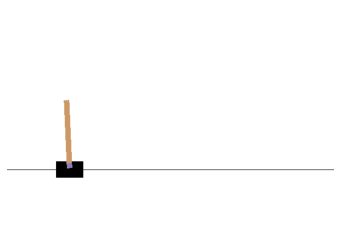

In [5]:
env = gym.make('CartPole-v0')
policy.load_state_dict(torch.load('REINFORCE_cartpole_checkpoint.pth', map_location='cpu'))
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()